In [14]:
import os

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import matplotlib.pylab as pl

# set data path
dir_path = pathlib.Path().absolute()
file = '../data/MOM4_data.csv'
data_path = os.path.join(dir_path, file)
print('MOM4 data located at:',data_path)

MOM4 data located at: /media/sda/Documents/github_kohyoung/data_analysis/../data/MOM4_data.csv


In [15]:
''' Read dataset '''
# configurations for plots
%matplotlib inline
%time # for timing
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# read data
df = pd.read_csv(data_path  ,index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0
df.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90,31.26,100.11,81.7355,75.6950,-51.9,63.3,-52.1,60.5,63.3,51.9,60.5,52.1,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90,31.83,100.11,83.1555,71.5083,-45.7,66.1,-48.3,61.3,66.1,45.7,61.3,48.3,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90,32.40,100.11,87.0870,67.2606,-48.6,75.8,-34.6,68.9,75.8,48.6,68.9,34.6,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90,32.97,100.11,80.0433,75.8866,-56.3,65.8,-44.9,60.4,65.8,56.3,60.4,44.9,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90,33.54,100.11,76.7088,74.0452,-48.9,69.7,-51.1,69.2,69.7,48.9,69.2,51.1,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


In [16]:
# find which (PartType, Orientation, Job) is missing

dfgroups = df.groupby(['PartType','Orient.','Job'])
reps = 15
stencils = 5*5 # solder offset
t = tqdm(dfgroups)
for idx, (name, group) in enumerate(t):    
    t.set_description(f'Checking: {name}')
    
    chiptype, orient, jobtype = name
    if chiptype == 'R0402':
        continue
    # 중복되는 job에 대해 15개 안되면 프린트
    jobcount = dict()
    for index, row in group.iterrows():
        job = row['Job']
        try:
            jobcount[job] += 1
        except:
            jobcount[job] = 1
    for key, values in jobcount.items():
        if values < (stencils * reps):
            print('Missing:\t', chiptype, f'/ {orient} deg /', jobtype, ':', 375-jobcount[key])

Checking: ('R1005', 90, 'Job_8_8'): 100%|██████████| 486/486 [00:08<00:00, 58.06it/s]


Missing:	 R0603 / 0 deg / Job_2_2 : 1
Missing:	 R1005 / 0 deg / Job_8_5 : 1
Missing:	 R1005 / 90 deg / Job_0_3 : 1


In [17]:
# find which CRD is missing

'''    
CRD: B if R0402, C if 0603, D if R1005
orient 0:  376-750 for each job
orient 90: 1-375 for each job
'''

# pull dataframe with conditions as found above
missing_chip = {0: 'R0603-0-Job_2_2', 1: 'R1005-0-Job_8_5', 2: 'R1005-90-Job_0_3'}

temp1 = df.loc[(df['PartType']=='R0603') & (df['Orient.']==0) & (df['Job']=='Job_2_2')]
temp2 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==0) & (df['Job']=='Job_8_5')]
temp3 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==90) & (df['Job']=='Job_0_3')]
temps = [temp1, temp2, temp3]

expected_crds_90deg = np.arange(1, 375, 1)
expected_crds_0deg = np.arange(376, 750, 1)

t = tqdm(temps)
for i, temp in enumerate(t):
    crds_orig = temp['CRD'].values
    crds = [int(crd[1:]) for crd in crds_orig]
    orient = temp['Orient.'].values[0]
    chiptype = temp['PartType'].values[0]
    t.set_description(f'Checking: ({chiptype}, {orient}, {crds_orig[i]})')
    if orient == 0:
        for item in expected_crds_0deg:
            if item not in crds:
                if chiptype == 'R0603':
                    print(f'Missing CRD in {missing_chip[i]}:\tC{item}')
                elif chiptype == 'R1005':
                    print(f'Missing CRD in {missing_chip[i]}:\tD{item}')
    else:
        for item in expected_crds_90deg:
            if item not in crds:
                if chiptype == 'R0603':
                    print(f'Missing CRD in {missing_chip[i]}:\tC{item}')
                elif chiptype == 'R1005':
                    print(f'Missing CRD in {missing_chip[i]}:\tD{item}')

Checking: (R1005, 90, D3): 100%|██████████| 3/3 [00:00<00:00, 106.35it/s]


Missing CRD in R0603-0-Job_2_2:	C395
Missing CRD in R1005-0-Job_8_5:	D492
Missing CRD in R1005-90-Job_0_3:	D143


In [18]:
missing_crd = {0: 'C395', 1: 'D492', 2: 'D143'}

In [19]:
temp1 = df.loc[(df['PartType']=='R0603') & (df['Orient.']==0) & (df['Job']=='Job_2_2')]
temp2 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==0) & (df['Job']=='Job_8_5')]
temp3 = df.loc[(df['PartType']=='R1005') & (df['Orient.']==90) & (df['Job']=='Job_0_3')]
temps = [temp1, temp2, temp3]

df.head()

,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_R,PRE_R,POST_R,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90,31.26,100.11,81.7355,75.6950,-51.9,63.3,-52.1,60.5,63.3,51.9,60.5,52.1,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,80.843120,19.972320,29.076321,78.71525,6.0405
1,B2,R0402,90,31.83,100.11,83.1555,71.5083,-45.7,66.1,-48.3,61.3,66.1,45.7,61.3,48.3,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,79.162428,27.640847,22.909526,77.33190,11.6472
2,B3,R0402,90,32.40,100.11,87.0870,67.2606,-48.6,75.8,-34.6,68.9,75.8,48.6,68.9,34.6,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,83.457070,33.071929,23.540538,77.17380,19.8264
3,B4,R0402,90,32.97,100.11,80.0433,75.8866,-56.3,65.8,-44.9,60.4,65.8,56.3,60.4,44.9,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,80.882446,24.242596,34.696027,77.96495,4.1567
4,B5,R0402,90,33.54,100.11,76.7088,74.0452,-48.9,69.7,-51.1,69.2,69.7,48.9,69.2,51.1,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,85.576296,8.781555,36.204901,75.37700,2.6636


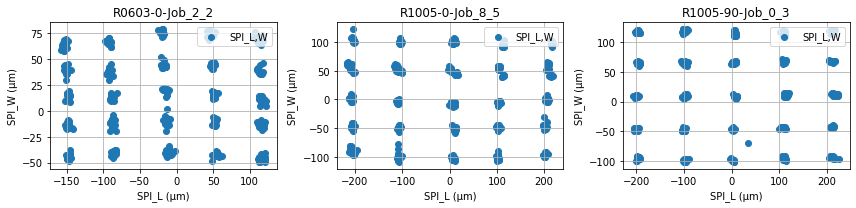

In [20]:
#### visualize (x, y)

xavg = 'SPI_L'
yavg = 'SPI_W'

# temp#_df: contains SPI_X_AVG and SPI_Y_AVG
temp1_df = temp1[[xavg, yavg]]
temp2_df = temp2[[xavg, yavg]]
temp3_df = temp3[[xavg, yavg]]

# visualize X, Y
fig = plt.figure(figsize=(12,3), facecolor='white')
for idx, group in enumerate([temp1, temp2, temp3]):
    # show average SPI X/Y
    x_group = group[xavg]
    y_group = group[yavg]
    ax = fig.add_subplot(1,3,idx+1)
    ax.scatter(x_group, y_group, label='SPI_L,W')
    ax.set_xlabel(f'{xavg} (\u03BCm)')
    ax.set_ylabel(f'{yavg} (\u03BCm)')
    ax.set_title(missing_chip[idx])
    ax.grid()
    ax.legend(loc='upper right')
    
    ''' show for each SPI_L1/W1, SPI_L2/W2
    x_group = group[x1]
    y_group = group[y1]
    ax = fig.add_subplot(2,3,idx+1)
    ax.scatter(x_group, y_group)
    ax.set_xlabel(x1)
    ax.set_ylabel(y1)
    ax.set_title(name)
    
    x_group = group[x2]
    y_group = group[y2]
    ax = fig.add_subplot(2,3,idx+4)
    ax.scatter(x_group, y_group)
    ax.set_xlabel(x2)
    ax.set_ylabel(y2)
    ax.set_title(name)
    '''
fig.tight_layout()
plt.show()

R0603-0-Job_2_2: centroid 5 (Count: 14)
R1005-0-Job_8_5: centroid 22 (Count: 14)
R1005-90-Job_0_3: centroid 0 (Count: 14)


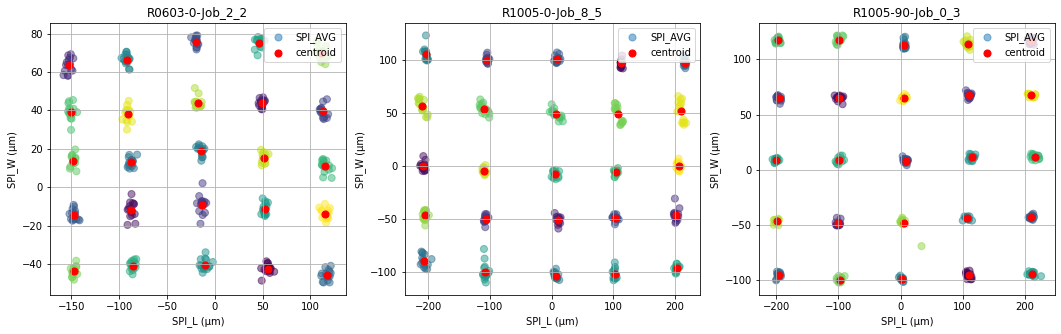

In [21]:
# clustering

from collections import defaultdict

def list_duplicates(seq):
    tally = defaultdict(list)
    for i,item in enumerate(seq):
        tally[item].append(i)
    return ((key,locs) for key,locs in tally.items() if len(locs)>1)

# 1. scikit learn - Kmeans
from sklearn.cluster import KMeans
missing_sample = dict()

fig = plt.figure(figsize=(18,5), facecolor='white')
temp_dfs = [temp1_df,temp2_df,temp3_df]
for temp_idx, temp_df in enumerate(temp_dfs):
    missing_sample[temp_idx] = []
    kmeans = KMeans(n_clusters=25).fit(temp_df)
    centroids = kmeans.cluster_centers_
    for dup in sorted(list_duplicates(kmeans.labels_)):
        if len(temp_df.iloc[dup[1],:]) < 15:
            missing_sample[temp_idx] = (dup[0], dup[1])
            chip_orient_job = missing_chip[temp_idx]
            print(f'{chip_orient_job}: centroid {dup[0]} (Count: {len(temp_df.iloc[dup[1],:])})')#' \n {temp_df.iloc[dup[1],:]} \n') # lists corresponding row indices for each centroid
        else:
            continue
    ax = fig.add_subplot(1,3,temp_idx+1)
    ax.scatter(temp_df[xavg], temp_df[yavg], c=kmeans.labels_.astype(float), s=50, alpha=0.5, label='SPI_AVG')
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, label='centroid')
    ax.set_xlabel(f'{xavg} (\u03BCm)')
    ax.set_ylabel(f'{yavg} (\u03BCm)')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_title(missing_chip[temp_idx])
plt.show()
fig.savefig('./stencils.png')

# 2. scipy - KMeans
# from scipy.cluster.vq import kmeans,vq
# from matplotlib import cm
# for temp_idx, temp_df in enumerate([temp1_df,temp2_df,temp3_df]):
#     centroids, _ = kmeans(temp_df, k_or_guess=25, thresh=1e-7)
#     plt.scatter(temp_df[xavg], temp_df[yavg], cmap=plt.get_cmap('jet'), s=50, alpha=0.5) # c=kmeans.labels_.astype(float),
#     plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
#     plt.show()v

#     idx, _ = vq(temp1_df, centroids)
#     # print(idx) # idx = lists the centroid numbers for each row (of SPI)
#     for dup in sorted(list_duplicates(idx)):
#         if len(temp_df.iloc[dup[1],:]) < 15:
#             chip_orient_job = missing_chip[temp_idx]
#             print(f'{chip_orient_job}: centroid {dup[0]} (Count: {len(temp_df.iloc[dup[1],:])}) \
#                     \n {temp_df.iloc[dup[1],:]} \n') # lists corresponding row indices for each centroid

# from scipy.spatial import distance
# distance.euclidean(centroids, temp1_df)


In [22]:
# check: (parttype, orient, job) sample
print('Sample:\n')
print(missing_chip[0])
print(temps[0].head(1))

# check centroid values
# missing sample contains (centroid number, index in temp_dfs[i] for the centroid)
# temp_dfs contains dataframe corresponding to the chosen indices (for the centroids)
print('Centroids:\n')
for i, (k, v) in enumerate(missing_sample.items()):
    print(f'{missing_chip[k]}:\n(index: {v}), \n(df: {temp_dfs[i].iloc[v[1],:].head(1)})')

Sample:

R0603-0-Job_2_2
        CRD PartType  Orient.     X     Y  SPI_VOLUME1  SPI_VOLUME2  SPI_X1  \
48374  C376    R0603        0  93.0  40.5      86.3048      88.1976   -24.4   

       SPI_Y1  SPI_X2  SPI_Y2  SPI_L1  SPI_W1  SPI_L2  SPI_W2  SPI_L  SPI_W  \
48374    22.6    -9.3    18.0   -24.4    22.6    -9.3    18.0 -16.85   20.3   

           PRE_X      PRE_Y  PRE_A      PRE_L      PRE_W     POST_X  \
48374 -82.308685 -27.567791 -2.289 -82.308685 -27.567791 -27.305178   

          POST_Y  POST_A     POST_L     POST_W      Job  Chip_L  Chip_W  \
48374 -11.435584     0.0 -27.305178 -11.435584  Job_2_2   600.0   300.0   

           SPI_R      PRE_R    POST_R  SPI_VOLUME_MEAN  SPI_VOLUME_DIFF  
48374  26.382049  86.802665  29.60313          87.2512          -1.8928  
Centroids:

R0603-0-Job_2_2:
(index: (5, [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])), 
(df:        SPI_L  SPI_W
48390  117.3  36.05)
R1005-0-Job_8_5:
(index: (22, [106, 107, 108, 109, 110, 111, 112, 1

In [23]:
# imputation: KNN Imputer(2 neighbors)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_temp_save = df.copy()
# df_temp_save = df.copy().drop(columns=['SPI_VOLUME1', 'SPI_VOLUME2', 'SPI_R','PRE_R','POST_R','SPI_VOLUME_DIFF'])
for i in range(len(missing_sample)):
    # tadd a nan row, impute NaN, add to original by index, reset index
    tmp = temps[i].iloc[missing_sample[i][1],:].append(pd.Series(dtype=float), ignore_index=True)
    
    # columns to impute: 
    cols_to_impute = ['X','Y', \
                      'SPI_VOLUME1','SPI_VOLUME2', 'SPI_VOLUME_MEAN',\
                      'SPI_L','SPI_W', \
                      'PRE_X','PRE_Y','PRE_A','PRE_L','PRE_W', \
                      'POST_X','POST_Y','POST_A','POST_L','POST_W', \
                      'Orient.']
    # drop CRD and PartType for imputation
    tmp = tmp[cols_to_impute]

    transformed = pd.DataFrame(imputer.fit_transform(tmp), columns=cols_to_impute).round(3)
    imputed = transformed.iloc[len(transformed)-1, :]
    
    centroid_index_start = temp_dfs[i].iloc[missing_sample[i][1],:].index[0]
    centroid_index_end = temp_dfs[i].iloc[missing_sample[i][1],:].index[-1]
    print('size changed: from',len(temp_dfs[i].iloc[missing_sample[i][1],:]), \
          'to', len(transformed), '/ indices corresp. to each centroid (from orig df): from',centroid_index_start, \
          'to', centroid_index_end)

    job,parttype,chipl,chipw,orient = df_temp_save.iloc[centroid_index_end, :][['Job','PartType','Chip_L','Chip_W','Orient.']]
    for col in list(df_temp_save.columns):
        if col not in cols_to_impute:
            # append random value to these columns
            if col == 'Job':
                imputed[col] = job
            elif col == 'PartType':
                imputed[col] = parttype
            elif col == 'Chip_L':
                imputed[col] = chipl
            elif col == 'Chip_W':
                imputed[col] = chipw
            elif col == 'Orient.':
                imputed[col] = orient
            elif col == 'CRD':
                imputed[col] = missing_crd[i]
            else:
                imputed[col] = np.nan
    assert len(imputed.index) == len(list(df_temp_save.columns))
#     print(imputed)
    df_temp_save = df_temp_save.append(imputed, ignore_index=True)
    
# scan for missing (parttype, orientation, job): 
# >> if none printed, then none missing! 
# >> all 15 reps, 25 stencil jobs, 81 chip jobs present
dfgroups = df_temp_save.groupby(['PartType','Orient.','Job'])
reps = 3*5     # chip offset
stencils = 5*5 # solder offset
t = tqdm(dfgroups)
for idx, (name, group) in enumerate(t):
    t.set_description(f'Checking: {name}')
    chiptype, orient, jobtype = name
    # 중복되는 job에 대해 15개 안되면 프린트
    jobcount = dict()
    for index, row in group.iterrows():
        job = row['Job']
        try:
            jobcount[job] += 1
        except:
            jobcount[job] = 1
    for key, values in jobcount.items():
        if values < (stencils * reps):
            print(chiptype, f'/ {orient} deg /', jobtype, ':', jobcount[key])

size changed: from 14 to 15 / indices corresp. to each centroid (from orig df): from 48390 to 48403
size changed: from 14 to 15 / indices corresp. to each centroid (from orig df): from 175229 to 175242
size changed: from 14 to 15 / indices corresp. to each centroid (from orig df): from 10635 to 10648


Checking: ('R1005', 90.0, 'Job_8_8'): 100%|██████████| 486/486 [00:12<00:00, 38.45it/s]


In [24]:
# check imputattion result 

new_temp1 = df_temp_save.loc[(df_temp_save['PartType']=='R0603') & (df_temp_save['Orient.']==0) & (df_temp_save['Job']=='Job_2_2')]
new_temp2 = df_temp_save.loc[(df_temp_save['PartType']=='R1005') & (df_temp_save['Orient.']==0) & (df_temp_save['Job']=='Job_8_5')]
new_temp3 = df_temp_save.loc[(df_temp_save['PartType']=='R1005') & (df_temp_save['Orient.']==90) & (df_temp_save['Job']=='Job_0_3')]

[len(temp) for temp in [new_temp1, new_temp2, new_temp3]]

[375, 375, 375]

In [25]:
df_imputed = df_temp_save.drop(columns=['SPI_R','PRE_R','POST_R'])
df_imputed.to_csv('../data/imputed_data.csv')


In [26]:
df_imputed.head(6)

,CRD,PartType,Orient.,X,Y,SPI_VOLUME1,SPI_VOLUME2,SPI_X1,SPI_Y1,SPI_X2,SPI_Y2,SPI_L1,SPI_W1,SPI_L2,SPI_W2,SPI_L,SPI_W,PRE_X,PRE_Y,PRE_A,PRE_L,PRE_W,POST_X,POST_Y,POST_A,POST_L,POST_W,Job,Chip_L,Chip_W,SPI_VOLUME_MEAN,SPI_VOLUME_DIFF
0,B1,R0402,90.0,31.26,100.11,81.7355,75.6950,-51.9,63.3,-52.1,60.5,63.3,51.9,60.5,52.1,61.90,52.0,-19.887293,-1.840963,-1.877,-1.840963,19.887293,-7.440417,28.108231,1.613,28.108231,7.440417,CENTER,400.0,200.0,78.71525,6.0405
1,B2,R0402,90.0,31.83,100.11,83.1555,71.5083,-45.7,66.1,-48.3,61.3,66.1,45.7,61.3,48.3,63.70,47.0,-26.766272,6.898049,-1.449,6.898049,26.766272,5.487133,22.242701,0.000,22.242701,-5.487133,CENTER,400.0,200.0,77.33190,11.6472
2,B3,R0402,90.0,32.40,100.11,87.0870,67.2606,-48.6,75.8,-34.6,68.9,75.8,48.6,68.9,34.6,72.35,41.6,-32.058273,8.125244,-3.278,8.125244,32.058273,-19.644203,12.971593,1.552,12.971593,19.644203,CENTER,400.0,200.0,77.17380,19.8264
3,B4,R0402,90.0,32.97,100.11,80.0433,75.8866,-56.3,65.8,-44.9,60.4,65.8,56.3,60.4,44.9,63.10,50.6,-23.437572,-6.195457,-3.337,-6.195457,23.437572,-22.517658,26.396389,0.000,26.396389,22.517658,CENTER,400.0,200.0,77.96495,4.1567
4,B5,R0402,90.0,33.54,100.11,76.7088,74.0452,-48.9,69.7,-51.1,69.2,69.7,48.9,69.2,51.1,69.45,50.0,-5.187286,7.085744,-3.408,7.085744,5.187286,-21.413681,29.193306,3.611,29.193306,21.413681,CENTER,400.0,200.0,75.37700,2.6636
5,B6,R0402,90.0,31.26,99.20,87.5890,67.7356,-48.0,54.8,-50.2,64.7,54.8,48.0,64.7,50.2,59.75,49.1,-31.059980,1.531298,3.611,1.531298,31.059980,-5.925862,17.682121,0.000,17.682121,5.925862,CENTER,400.0,200.0,77.66230,19.8534
